## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

- [X] Create a time split 80 - 20 per city (there are more years to train and predict for sj than iq)
- [X] Create a basic baseline model with all features 'as is' (bad performance expected)
- [X] Create a basic model only non-correlated features
- [X] One model per city
- [X] Normalize features
- [X] Obtain feature importance
- [ ] Implement time delay using moving averages

In [87]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
import numpy as np
import hydra
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

### Load data

In [88]:
data_folder = 'data'
features_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
features_test_path = 'dengue_features_test.csv'

In [89]:
features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
features_test = pd.read_csv(os.path.join(data_folder, features_test_path))

### Basic Pre-processing

In [90]:
# transform week_start_date into a datetime feature
features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

In [91]:
# Merge features and labels for easier exploration
train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])

In [92]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [93]:
fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
for col in tqdm(fill_ma_cols):
    fill_ma(train_df, col)

  0%|          | 0/20 [00:00<?, ?it/s]

In [94]:
train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

In [95]:
### Split train - eval

In [96]:
iq_train_years = sorted(train_df[train_df.city == 'iq'][['year']].drop_duplicates().values)[:int(train_df[train_df.city == 'iq'][['year']].nunique() * 0.8)]
iq_eval_years = sorted(train_df[train_df.city == 'iq'][['year']].drop_duplicates().values)[int(train_df[train_df.city == 'iq'][['year']].nunique() * 0.8):]
sj_train_years = sorted(train_df[train_df.city == 'sj'][['year']].drop_duplicates().values)[:int(train_df[train_df.city == 'sj'][['year']].nunique() * 0.8)]
sj_eval_years = sorted(train_df[train_df.city == 'sj'][['year']].drop_duplicates().values)[int(train_df[train_df.city == 'sj'][['year']].nunique() * 0.8):]

In [97]:
eval_df = train_df[(train_df.city == 'sj') & (train_df.year.isin(sj_eval_years)) | (train_df.city == 'iq') & (train_df.year.isin(iq_eval_years))]
train_df = train_df[(train_df.city == 'sj') & (train_df.year.isin(sj_train_years)) | (train_df.city == 'iq') & (train_df.year.isin(iq_train_years))]

In [72]:
eval_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
763,sj,2005,0,2005-01-01,0.008097,0.033793,0.201634,0.171328,98.035194,298.692355,...,83.057408,98.035194,16.947499,3.480449,26.714320,6.886807,31.226219,22.451075,47.51318,10
764,sj,2005,1,2005-01-08,0.007900,-0.049633,0.124657,0.100443,0.000000,297.587143,...,74.778571,0.000000,14.261429,1.957143,24.985714,4.900000,28.300000,21.100000,23.80000,15
765,sj,2005,2,2005-01-15,0.024350,-0.019275,0.133543,0.127243,0.000000,297.600000,...,78.798571,0.000000,15.042857,1.914286,25.200000,5.385714,28.300000,22.200000,55.60000,17
766,sj,2005,3,2005-01-22,-0.111833,-0.076450,0.202900,0.223357,14.670000,297.395714,...,83.055714,14.670000,15.671429,1.914286,25.228571,4.914286,28.300000,21.700000,32.40000,7
767,sj,2005,4,2005-01-29,-0.047900,0.043100,0.174300,0.145643,15.200000,296.535714,...,78.538571,15.200000,14.091429,2.657143,23.757143,6.328571,28.300000,17.800000,34.00000,7


In [366]:
list(train_df.select_dtypes(include=np.number).columns)

['year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [367]:
[col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)]

['city', 'week_start_date']

In [368]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in list(train_df.select_dtypes(include=np.number).columns) if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [369]:
num_cols

['year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

In [370]:
cat_cols

['city']

In [371]:
train_cat_df = pd.get_dummies(train_df[cat_cols])

In [372]:
features_eval

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city_iq,city_sj
763,2005,0,0.008097,0.033793,0.201634,0.171328,98.035194,298.692355,299.048503,295.493893,...,98.035194,16.947499,3.480449,26.714320,6.886807,31.226219,22.451075,47.51318,0,1
764,2005,1,0.007900,-0.049633,0.124657,0.100443,0.000000,297.587143,297.664286,292.771429,...,0.000000,14.261429,1.957143,24.985714,4.900000,28.300000,21.100000,23.80000,0,1
765,2005,2,0.024350,-0.019275,0.133543,0.127243,0.000000,297.600000,297.614286,293.667143,...,0.000000,15.042857,1.914286,25.200000,5.385714,28.300000,22.200000,55.60000,0,1
766,2005,3,-0.111833,-0.076450,0.202900,0.223357,14.670000,297.395714,297.557143,294.308571,...,14.670000,15.671429,1.914286,25.228571,4.914286,28.300000,21.700000,32.40000,0,1
767,2005,4,-0.047900,0.043100,0.174300,0.145643,15.200000,296.535714,296.614286,292.512857,...,15.200000,14.091429,2.657143,23.757143,6.328571,28.300000,17.800000,34.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2010,21,0.342750,0.318900,0.256343,0.292514,55.300000,299.334286,300.771429,296.825714,...,55.300000,18.485714,9.800000,28.633333,11.933333,35.400000,22.400000,27.00000,1,0
1452,2010,22,0.160157,0.160371,0.136043,0.225657,86.470000,298.330000,299.392857,296.452857,...,86.470000,18.070000,7.471429,27.433333,10.500000,34.700000,21.700000,36.60000,1,0
1453,2010,23,0.247057,0.146057,0.250357,0.233714,58.940000,296.598571,297.592857,295.501429,...,58.940000,17.008571,7.500000,24.400000,6.900000,32.200000,19.200000,7.40000,1,0
1454,2010,24,0.333914,0.245771,0.278886,0.325486,59.670000,296.345714,297.521429,295.324286,...,59.670000,16.815714,7.871429,25.433333,8.733333,31.200000,21.000000,16.00000,1,0


In [373]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [374]:
model = 'sklearn.svm.SVR'

In [375]:
clf = hydra.utils.get_class(model)(kernel='linear')

In [376]:
clf = clf.fit(features_train, label_train)

In [377]:
y_hat = clf.predict(features_eval)

In [378]:
mean_absolute_error(label_eval, y_hat)

71.10740236668546

### Only non-correlated features

In [592]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [593]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [633]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [634]:
features_train.head()

,weekofyear,ndvi_ne,ndvi_sw,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_precip_mm,city_iq,city_sj
0,18,0.122600,0.177617,14.012857,25.442857,16.0,0,1
1,19,0.169900,0.155486,15.372857,26.714286,8.6,0,1
2,20,0.032250,0.170843,16.848571,26.714286,41.4,0,1
3,21,0.128633,0.235886,16.672857,27.471429,4.0,0,1
4,22,0.196200,0.247340,17.210000,28.942857,5.8,0,1


In [635]:
model = 'sklearn.svm.SVR'

In [636]:
clf = hydra.utils.get_class(model)(kernel='linear')

In [687]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [688]:
clf = clf.fit(features_train, label_train)

c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.w

In [689]:
y_hat = clf.predict(features_eval)

In [690]:
mean_absolute_error(label_eval, y_hat)

16.061741731122996

In [527]:
clf.feature_names_in_

array(['weekofyear', 'ndvi_ne', 'reanalysis_specific_humidity_g_per_kg',
       'station_avg_temp_c', 'station_precip_mm', 'city_iq', 'city_sj'],
      dtype=object)

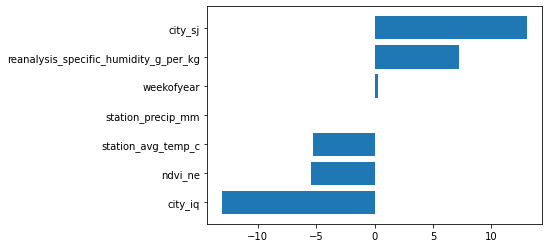

In [528]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(clf.coef_[0], clf.feature_names_in_)

### One model per city

In [461]:
initial_list = [
    'weekofyear',
#  'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
#  'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [462]:
y_real = []
y_pred = []
for city in ['sj', 'iq']:
    features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
    labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
    features_test = pd.read_csv(os.path.join(data_folder, features_test_path))
    # transform week_start_date into a datetime feature
    
    features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)
    
    # Merge features and labels for easier exploration
    train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])
    
    fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
    for col in tqdm(fill_ma_cols):
        fill_ma(train_df, col)
    train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)
    train_years = sorted(train_df[train_df.city == city][['year']].drop_duplicates().values)[:int(train_df[train_df.city == city][['year']].nunique() * 0.8)]
    eval_years = sorted(train_df[train_df.city == city][['year']].drop_duplicates().values)[int(train_df[train_df.city == city][['year']].nunique() * 0.8):]

    eval_df = train_df[(train_df.city == city) & (train_df.year.isin(eval_years))]
    train_df = train_df[(train_df.city == city) & (train_df.year.isin(train_years))]
    
    TARGET = 'total_cases'
    ignore_cols = ['week_start_date'] + [TARGET]
    num_cols = [col for col in initial_list if col not in ignore_cols]
    
    features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
    label_train = train_df[TARGET]
    features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
    label_eval = eval_df[TARGET]
    
    model = 'sklearn.svm.SVR'
    clf = hydra.utils.get_class(model)(kernel='linear')
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    y_pred.extend(y_hat)
    y_real.extend(label_eval)
    print(city, mean_absolute_error(label_eval, y_hat))
print(mean_absolute_error(y_real, y_pred))

  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

sj 29.269045462044097


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

iq 13.044167749490034
24.227051591210557


### Scaled features

In [98]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [99]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [100]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [101]:
scaler = preprocessing.StandardScaler().fit(features_train)
# scaler = preprocessing.MinMaxScaler().fit(features_train)

In [102]:
features_train = scaler.transform(features_train)
features_eval = scaler.transform(features_eval)
#scaler = preprocessing.MinMaxScaler().fit(features_train)
#features_train = scaler.transform(features_train)
#features_eval = scaler.transform(features_eval)

In [103]:
model = 'sklearn.svm.SVR'

In [104]:
clf = hydra.utils.get_class(model)()#(kernel='linear')

In [57]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [105]:
clf = clf.fit(features_train, label_train)

In [106]:
y_hat = clf.predict(features_eval)

In [107]:
mean_absolute_error(label_eval, y_hat)

21.160166863290996